# 📈 Candy Sales Forecasting

This notebook builds sales forecasting models using Random Forest and Gradient Boosting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Data path
DATA_PATH = Path('../../DataSource')
OUTPUT_PATH = Path('../outputs/predictions')
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

## 1. Load and Prepare Data

In [2]:
# Load data
sales = pd.read_csv(DATA_PATH / 'Candy_Sales.csv')
products = pd.read_csv(DATA_PATH / 'Candy_Products.csv')

# Parse dates
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
sales['Year'] = sales['Order Date'].dt.year
sales['Month'] = sales['Order Date'].dt.month
sales['Quarter'] = sales['Order Date'].dt.quarter
sales['DayOfWeek'] = sales['Order Date'].dt.dayofweek
sales['WeekOfYear'] = sales['Order Date'].dt.isocalendar().week.astype(int)

print(f"Loaded {len(sales)} records")
print(f"Date range: {sales['Order Date'].min()} to {sales['Order Date'].max()}")

Loaded 10194 records
Date range: 2021-01-03 00:00:00 to 2024-12-30 00:00:00


In [3]:
# Aggregate to monthly level for forecasting
monthly_sales = sales.groupby(['Year', 'Month']).agg({
    'Sales': 'sum',
    'Units': 'sum',
    'Cost': 'sum',
    'Gross Profit': 'sum',
    'Order ID': 'nunique'
}).reset_index()
monthly_sales.columns = ['Year', 'Month', 'Sales', 'Units', 'Cost', 'GrossProfit', 'Orders']

# Create date index
monthly_sales['Date'] = pd.to_datetime(monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str) + '-01')
monthly_sales = monthly_sales.sort_values('Date').reset_index(drop=True)

print(f"Monthly records: {len(monthly_sales)}")
monthly_sales.head()

Monthly records: 48


,Year,Month,Sales,Units,Cost,GrossProfit,Orders,Date
0,2021,1,1065.24,306,361.24,704.00,61,2021-01-01
1,2021,2,547.09,159,189.02,358.07,40,2021-02-01
2,2021,3,2245.63,597,820.34,1425.29,132,2021-03-01
3,2021,4,2058.97,536,733.84,1325.13,113,2021-04-01
4,2021,5,1855.21,504,646.98,1208.23,118,2021-05-01


## 2. Feature Engineering

In [4]:
# Create lag features
for lag in [1, 2, 3, 6, 12]:
    monthly_sales[f'Sales_Lag{lag}'] = monthly_sales['Sales'].shift(lag)

# Rolling statistics
monthly_sales['Sales_MA3'] = monthly_sales['Sales'].rolling(window=3).mean()
monthly_sales['Sales_MA6'] = monthly_sales['Sales'].rolling(window=6).mean()
monthly_sales['Sales_Std3'] = monthly_sales['Sales'].rolling(window=3).std()

# Quarter indicator
monthly_sales['Quarter'] = monthly_sales['Month'].apply(lambda x: (x-1)//3 + 1)

# Drop rows with NaN from lag features
monthly_sales_clean = monthly_sales.dropna().copy()
print(f"Records after feature engineering: {len(monthly_sales_clean)}")

Records after feature engineering: 36


In [5]:
# Define features and target
feature_cols = ['Year', 'Month', 'Quarter', 'Sales_Lag1', 'Sales_Lag2', 'Sales_Lag3', 
                'Sales_Lag6', 'Sales_Lag12', 'Sales_MA3', 'Sales_MA6', 'Sales_Std3']

X = monthly_sales_clean[feature_cols]
y = monthly_sales_clean['Sales']

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

Features: 11
Samples: 36


## 3. Train/Test Split

In [6]:
# Time-based split (use last 6 months as test)
test_size = 6
X_train = X.iloc[:-test_size]
X_test = X.iloc[-test_size:]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

print(f"Train set: {len(X_train)} months")
print(f"Test set: {len(X_test)} months")

Train set: 30 months
Test set: 6 months


## 4. Model Training

In [7]:
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Results:")
print(f"  MAE: ${mean_absolute_error(y_test, rf_pred):,.2f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, rf_pred)):,.2f}")
print(f"  R²: {r2_score(y_test, rf_pred):.3f}")

Random Forest Results:
  MAE: $1,169.09
  RMSE: $1,354.62
  R²: 0.282


In [8]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

print("Gradient Boosting Results:")
print(f"  MAE: ${mean_absolute_error(y_test, gb_pred):,.2f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test, gb_pred)):,.2f}")
print(f"  R²: {r2_score(y_test, gb_pred):.3f}")

Gradient Boosting Results:
  MAE: $1,044.53
  RMSE: $1,176.91
  R²: 0.458


## 5. Model Comparison

In [9]:
# Compare predictions
results_df = pd.DataFrame({
    'Date': monthly_sales_clean['Date'].iloc[-test_size:].values,
    'Actual': y_test.values,
    'RF_Prediction': rf_pred,
    'GB_Prediction': gb_pred
})

results_df['RF_Error'] = results_df['Actual'] - results_df['RF_Prediction']
results_df['GB_Error'] = results_df['Actual'] - results_df['GB_Prediction']

print("Prediction Comparison:")
print(results_df.to_string(index=False))

Prediction Comparison:
      Date  Actual  RF_Prediction  GB_Prediction    RF_Error    GB_Error
2024-07-01 2991.39    3252.984240    2859.972244 -261.594240  131.417756
2024-08-01 3208.37    2916.572352    2747.861401  291.797648  460.508599
2024-09-01 6443.52    4778.603392    5117.263456 1664.916608 1326.256544
2024-10-01 4541.81    3466.313320    3093.136431 1075.496680 1448.673569
2024-11-01 6747.64    4833.477644    5202.842281 1914.162356 1544.797719
2024-12-01 6675.91    4869.346863    5320.397929 1806.563137 1355.512071


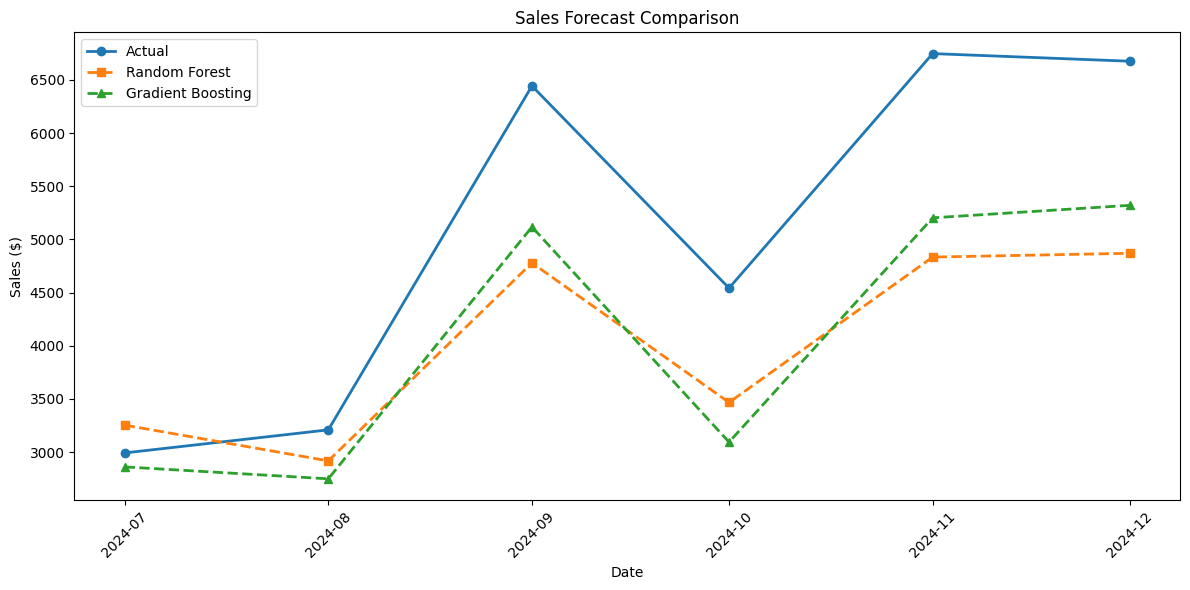

In [10]:
# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(results_df['Date'], results_df['Actual'], 'o-', label='Actual', linewidth=2)
ax.plot(results_df['Date'], results_df['RF_Prediction'], 's--', label='Random Forest', linewidth=2)
ax.plot(results_df['Date'], results_df['GB_Prediction'], '^--', label='Gradient Boosting', linewidth=2)

ax.set_title('Sales Forecast Comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Sales ($)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Feature Importance

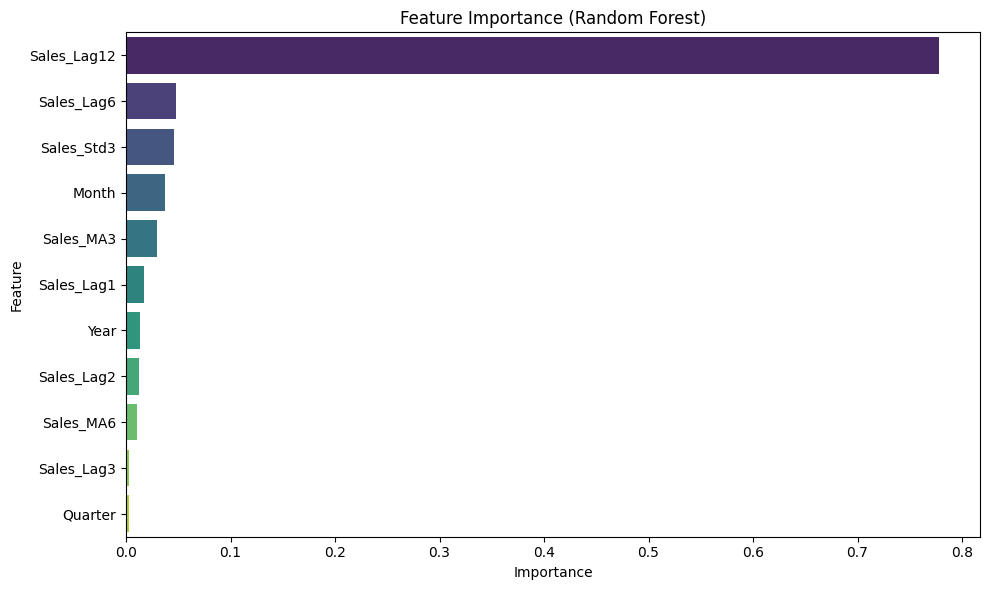

In [11]:
# Feature importance from RF
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax, palette='viridis')
ax.set_title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

## 7. Future Forecast

In [12]:
# Generate forecast for next 6 months
# Use the best model (GB has better R²)
best_model = gb_model

# Get last known values
last_row = monthly_sales_clean.iloc[-1]
last_date = last_row['Date']

# Create future predictions
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')
forecasts = []

# Use simple mean for future predictions (simplified approach)
avg_sales = monthly_sales_clean['Sales'].mean()
seasonal_factors = monthly_sales_clean.groupby('Month')['Sales'].mean() / avg_sales

for date in future_dates:
    month = date.month
    forecast = avg_sales * seasonal_factors.get(month, 1.0) * 1.1  # 10% growth assumption
    forecasts.append({
        'Date': date,
        'Month': month,
        'Year': date.year,
        'Forecast': forecast
    })

forecast_df = pd.DataFrame(forecasts)
print("6-Month Forecast:")
print(forecast_df.to_string(index=False))

6-Month Forecast:
      Date  Month  Year    Forecast
2025-01-01      1  2025 1656.512000
2025-02-01      2  2025 1241.691000
2025-03-01      3  2025 2682.720333
2025-04-01      4  2025 2512.286333
2025-05-01      5  2025 3172.396333
2025-06-01      6  2025 2894.928667


## 8. Export Results

In [13]:
# Save forecast
forecast_df.to_csv(OUTPUT_PATH / 'sales_forecast.csv', index=False)
print(f"Saved forecast to {OUTPUT_PATH / 'sales_forecast.csv'}")

# Model metrics summary
metrics = {
    'Model': ['Random Forest', 'Gradient Boosting'],
    'MAE': [mean_absolute_error(y_test, rf_pred), mean_absolute_error(y_test, gb_pred)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, rf_pred)), np.sqrt(mean_squared_error(y_test, gb_pred))],
    'R2': [r2_score(y_test, rf_pred), r2_score(y_test, gb_pred)]
}
metrics_df = pd.DataFrame(metrics)
print("\nModel Performance Summary:")
print(metrics_df.to_string(index=False))

Saved forecast to ..\outputs\predictions\sales_forecast.csv

Model Performance Summary:
            Model         MAE        RMSE       R2
    Random Forest 1169.088445 1354.615919 0.282243
Gradient Boosting 1044.527710 1176.914277 0.458205
